In this notebook, we compare the data-scaling of different learning algorithms on the CIAR-10 test set.

The methods we compare are:
1. Random guessing
2. Training a DNN from scratch. (Bahri et al., Rosenfeld et al.)
3. Linear probe on top of a pretrained model. (CLIP, LAION CLIP)
4. Finetuning a pretrained model.

### Load libraries

In [1]:
import os
import pathlib
import sys
from typing import Optional, Type

import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import transformers
import wandb
import wandb.apis.public
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src import utils
from src.pretrain import gen_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10
from src.pretrain.models import BaseEmbedderConfig, get_embedder_index

transformers.logging.set_verbosity_error()

### Load wandb data

In [2]:
api = wandb.Api(timeout=30)
runs: list[wandb.apis.public.Run] = api.runs(
    f"data-frugal-learning/probe-embeddings",
    filters={"tags": {"$in": ["probe-embeddings-v2"]}},
)
len(runs)

95

In [3]:
def get_df_from_run(run: wandb.apis.public.Run) -> pd.DataFrame:
    artifact = api.artifact(
        f"data-frugal-learning/probe-embeddings/run-{run.id}-df_scaling:v0",
    )
    ret_df = utils.artifact_to_df(artifact)

    ret_df["dataset_id"] = run.config["dataset_cfg"]["id"]
    ret_df["embedder_id"] = run.config["embedder_cfg"]["id"]
    ret_df["embed_dim"] = run.summary["embed_dim"]
    ret_df["n_embedder_params"] = run.summary["n_embedder_params"]

    return ret_df


# TODO: Find way to cache files instead of redownloading them every time
dfs = [get_df_from_run(run) for run in tqdm(runs)]
df = pd.concat(dfs, ignore_index=True)
df["model"] = df["embedder_id"]
df["model_type"] = df["embedder_id"].apply(
    lambda x: x.split("-")[0] if x.startswith("hf/") else x[:9],
)
df

100%|██████████| 95/95 [01:04<00:00,  1.47it/s]


,c,max_iter,seed,use_gpu,acc,xent,n_train,per_class,probe,cls_start,...,k,metric,err,hyper,dataset_id,embedder_id,embed_dim,n_embedder_params,model,model_type
0,0.01,10000.0,0.0,True,0.745141,inf,1,False,linear,0,...,NaN,None,0.254859,c=0.01,svhn,openai/ViT-L/14@336px,768,304293888,openai/ViT-L/14@336px,openai/Vi
1,1.00,10000.0,0.0,True,0.745141,inf,1,False,linear,0,...,NaN,None,0.254859,c=1.0,svhn,openai/ViT-L/14@336px,768,304293888,openai/ViT-L/14@336px,openai/Vi
2,100.00,10000.0,0.0,True,0.745141,inf,1,False,linear,0,...,NaN,None,0.254859,c=100.0,svhn,openai/ViT-L/14@336px,768,304293888,openai/ViT-L/14@336px,openai/Vi
3,NaN,NaN,NaN,True,0.745141,NaN,2,False,knn,0,...,1.0,euclidean,0.254859,k=1.0,svhn,openai/ViT-L/14@336px,768,304293888,openai/ViT-L/14@336px,openai/Vi
4,0.01,10000.0,0.0,True,0.745141,inf,2,False,linear,0,...,NaN,None,0.254859,c=0.01,svhn,openai/ViT-L/14@336px,768,304293888,openai/ViT-L/14@336px,openai/Vi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280158,NaN,NaN,NaN,True,0.986700,NaN,5000,True,knn,0,...,3.0,euclidean,0.013300,k=3.0,cifar10,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,1408,1011203840,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,hf/laion/CLIP
280159,NaN,NaN,NaN,True,0.986300,NaN,5000,True,knn,0,...,10.0,euclidean,0.013700,k=10.0,cifar10,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,1408,1011203840,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,hf/laion/CLIP
280160,0.01,10000.0,0.0,True,0.987100,0.045688,5000,True,linear,0,...,NaN,None,0.012900,c=0.01,cifar10,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,1408,1011203840,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,hf/laion/CLIP
280161,1.00,10000.0,0.0,True,0.986100,inf,5000,True,linear,0,...,NaN,None,0.013900,c=1.0,cifar10,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,1408,1011203840,hf/laion/CLIP-ViT-g-14-laion2B-s12B-b42K,hf/laion/CLIP


### Load transcribed data from papers

In [4]:
df_bahri = pd.read_csv(GIT_ROOT / "data/bahri-cifar10/wpd-clean.csv")

df_prune_scratch = pd.read_csv(
    GIT_ROOT / "data/sorscher-cifar10/scratch/wpd-clean.csv"
)
df_prune_scratch["err"] = df_prune_scratch.errp / 100

df_prune_transfer = pd.read_csv(
    GIT_ROOT / "data/sorscher-cifar10/transfer/wpd-clean.csv"
)

df_rosenfeld = pd.read_csv(
    GIT_ROOT / "data/rosenfeld-cifar10/wpd-clean.csv"
)

In [8]:

df_rosenfeld.tail()

,n_train,err
1,3125,0.277619
2,6250,0.183800
3,12500,0.117127
4,25000,0.070754
5,50000,0.044831


### Generate plots

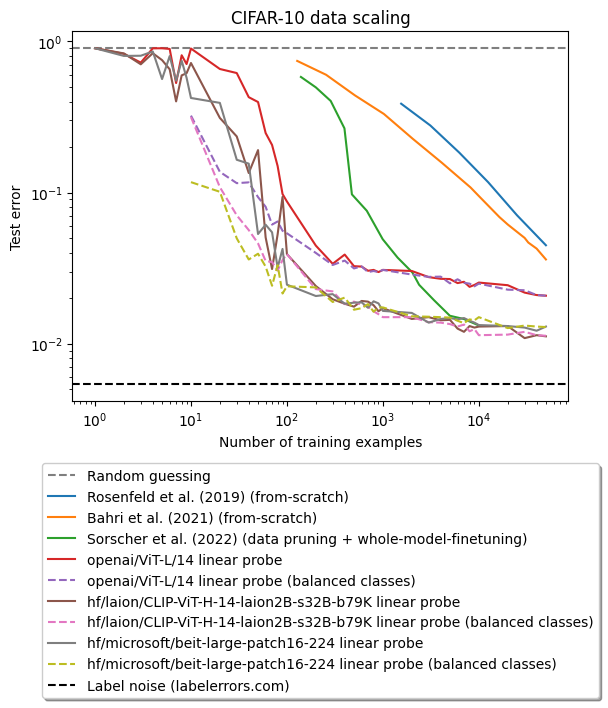

In [24]:
plt.axhline(
    0.9,
    color="k",
    linestyle="--",
    label="Random guessing",
    zorder=-10,
    alpha=0.5,
)

plt.plot(
    df_rosenfeld.n_train, df_rosenfeld.err, label="Rosenfeld et al. (2019) (from-scratch) "
)
plt.plot(df_bahri.n_train, df_bahri.err, label="Bahri et al. (2021) (from-scratch)")
# plt.plot(
#     df_prune_scratch.n_train,
#     df_prune_scratch.err,
#     label="Pruning paper (from scratch)",
# )
plt.plot(
    df_prune_transfer.n_train,
    df_prune_transfer.err,
    label="Sorscher et al. (2022) (data pruning + whole-model-finetuning)",
)

# hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K
def plot_err(
    df: pd.DataFrame,
    per_class: bool = False,
    **kwargs,
):
    df = df.query(f"per_class == {per_class}")
    if per_class:
        plt.plot(10 * df.n_train, df.err, **kwargs)
    else:
        plt.plot(df.n_train, df.err, **kwargs)


cdf = df.query(
    "&".join(
        (
            "dataset_id == 'cifar10'",
            "cls_start == 0",
            "cls_end == 10",
        )
    )
)

for embedder_id in (
    "openai/ViT-L/14",
    "hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
    "hf/microsoft/beit-large-patch16-224",
):
    plot_err(
        cdf.query(
            "probe == 'linear' & c == 0.01 & embedder_id == @embedder_id"
        ),
        label=f"{embedder_id} linear probe",
    )
    plot_err(
        cdf.query(
            "probe == 'linear' & c == 0.01 & embedder_id == @embedder_id"
        ),
        label=f"{embedder_id} linear probe (balanced classes)",
        per_class=True,
        linestyle="--",
    )

# plot_err(
#     cdf.query("probe == 'knn' & k == 3"),
#     label=f"{embedder_id} knn probe",
# )
# plot_err(
#     cdf.query("probe == 'knn' & k == 3"),
#     label=f"{embedder_id} linear probe (balanced classes",
#     per_class=True,
#     linestyle="--",
# )

plt.axhline(
    54 / 10000,
    color="k",
    linestyle="--",
    label="Label noise (labelerrors.com)",
    zorder=-10,
)

plt.title(f"CIFAR-10 data scaling")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of training examples")
plt.ylabel(f"Test error")

# Plot legend underneath plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    shadow=True,
    ncol=1,
)
plt.show()